In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm #progress bar
from skimage.filters import threshold_otsu, threshold_isodata #predefined 2D img
from skimage.morphology import binary_erosion, binary_dilation
from utils import * #used for ploting etc
from skimage.metrics import hausdorff_distance #

In [3]:
#table used for comparison dice segm coeff for each method
results = pd.read_csv('final_results.csv', index_col=0)
results.sort_values('otsu_dsc')

,svm_dsc,kmeans_dsc,svm_hausdorf,kmeans_hausdorf,otsu_dsc,otsu_hausdorf,isodata_dsc,isodata_hausdorf,rand_forest_dsc,rand_forest_hausdorf
patients,,,,,,,,,,
146,0.460135,0.127442,71.449283,77.942286,0.000000,89.877695,0.000000,89.682774,0.560862,75.246262
263,0.302757,0.339240,115.451288,122.759928,0.000000,119.570063,0.000000,121.350731,0.838376,115.723809
142,0.199422,0.065969,95.608577,101.084123,0.000000,81.443232,0.000000,82.680106,0.552626,92.956979
286,0.313042,0.016094,123.911259,129.830659,0.000000,75.272837,0.000000,75.272837,0.493306,39.306488
209,0.464063,0.239814,85.656290,87.846457,0.000000,78.319857,0.000000,78.319857,0.451330,85.936023
164,0.683966,0.439655,70.384657,84.005952,0.000000,78.294317,0.000000,78.294317,0.587883,74.572113
176,0.690602,0.509539,75.491721,83.336667,0.000000,88.549421,0.000000,88.549421,0.655292,84.864598
61,0.195023,0.177810,54.460995,62.737549,0.000000,76.746335,0.000000,76.746335,0.625054,31.827661
89,0.745096,0.367927,47.265209,68.571131,0.000000,92.141196,0.000000,92.141196,0.557593,34.190642


In [4]:
validation_set = [67, 107,  89, 276, 109, 199, 352,  51, 326, 165,  92, 286, 244,
                  142, 281, 132, 365, 176, 128, 333,  63, 209, 191, 164, 106,  61,
                  120, 259, 263, 146] #patients used for testing, same for all me and vlad and alex

test_patient = 276 #patient nr which i will test (369)
training_set = True #from which set is our patient, if from valid set is false

if training_set: #path to the folders,  define which path does the patient belong
    brats_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    dataset_part = "_Training_"
else:
    brats_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    dataset_part="_Validation_"


# Thresholding

## Handy functions

In [5]:
def k_opening(image, k):
    """Performs first erosion and then dialation on a given image k times

    Args:
        image (np.ndarra): 2D or 3D binary image
        k (int): How many times to do the operations 

    Returns:
        np,ndarray: Image after erosions and dialations
    """
    for i in range(k):
        image = binary_erosion(image)

    for i in range(k):
        image = binary_dilation(image)
    return image



In [6]:
def global_slice_thresholding(test_slice, k=3, max_tumor_prc=0.35): 
    """Performs global thresholding through Otsu/Isodata on a given image/MRI slice

    Args:
        test_slice (np.ndarray): 2D image / Slice
        min_area_threshold (float, optional): Min area. Defaults to 0.35.
        k (int, optional): Number of erosions and dialations to perform. Defaults to 3.
        max_tumor_prc (float, optional): Maximmun tumor proportion in the brain.
        If segmented region is bigger than this number, the whole slice is set to 0. Defaults to 0.35.

    Returns:
        otsu_mask_morph, isodata_mask_morph: Segmented mask for Otsu and Isodata
    """
    #Check if region is foreground or tumor
    otsu_mask = (test_slice > threshold_otsu( 
        test_slice[test_slice != 0])).astype(int)
    otsu_mask[test_slice == 0] = 0  
    
    #Check if region is foreground or tumor
    isodata_mask = (test_slice > threshold_isodata( 
        test_slice[test_slice != 0])).astype(int)
    isodata_mask[test_slice == 0] = 0  

    otsu_mask_morph = k_opening(otsu_mask, k) 
    #Apriori information, max_tumor_prc = 0.35
    if otsu_mask_morph.sum()/((test_slice>0).sum()) > max_tumor_prc: 
        otsu_mask_morph = np.zeros(otsu_mask_morph.shape) 

    isodata_mask_morph = k_opening(isodata_mask, k)
    #Apriori information, region should not be greater than max_tumor_prc in order to be tumor
    if isodata_mask_morph.sum()/((test_slice>0).sum()) > max_tumor_prc:
        isodata_mask_morph = np.zeros(isodata_mask_morph.shape)
    return otsu_mask_morph, isodata_mask_morph


In [7]:
def threshold_patient(patient_data, modality=4):
    """Performs thresholding on all slices of a given patient to obtain a 3D mask.

    Args:
        patient_data (np.ndarray(1, 5,x_dim,y_dim,z_dim)): Patients MRI scans and segmentation mask in the order
        modality (int, optional): MRI modality to use for thresholding. Defaults to 4.

    Returns:
        segm_mask_otsu, segm_mask_isodata: 3D volumes of segmentation masks
    """
    segm_mask_otsu = np.zeros(patient_data[0,0].shape) 
    segm_mask_isodata = np.zeros(patient_data[0,0].shape)
    
    #Do slice by slice segmentation
    for slice_idx in range(155): 
        if (patient_data[0, modality, :, :, slice_idx] > 0).sum() > 1: #Not empty slice
        
            otsu_mask_morph, isodata_mask_morph = global_slice_thresholding((patient_data[0, modality, :, :, slice_idx]))
        else:
            isodata_mask_morph = np.zeros((240,240)) 
            otsu_mask_morph = np.zeros((240,240))
            
        segm_mask_isodata[:,:, slice_idx] = isodata_mask_morph
        segm_mask_otsu[:,:, slice_idx] = otsu_mask_morph
    return segm_mask_otsu, segm_mask_isodata

## Segmentation Results

In [8]:
patient_data = retrieve_brats_data([test_patient], ['t1', 't2', 't1ce', 'flair'], dataset_part=dataset_part, brats_path=brats_path)
segm_mask_otsu, segm_mask_isodata = threshold_patient(patient_data) 

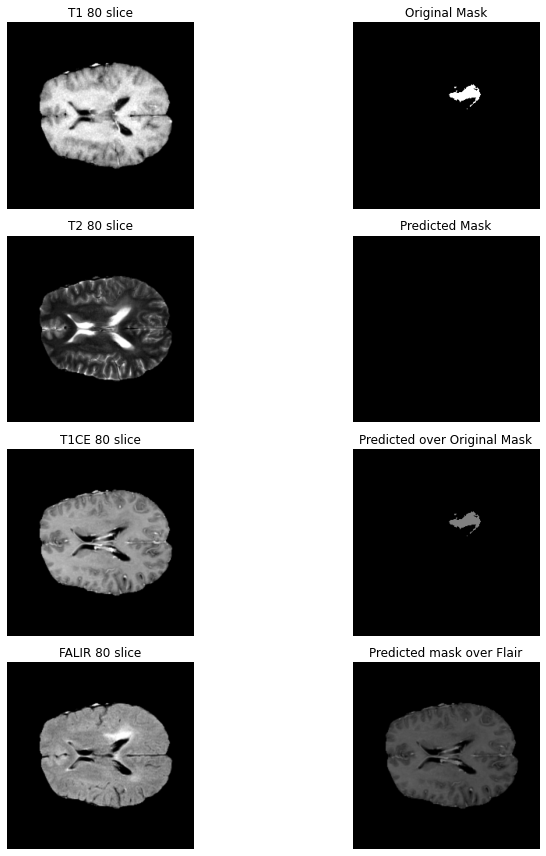

In [9]:
plot_results(patient_data, segm_mask_otsu, 80) 

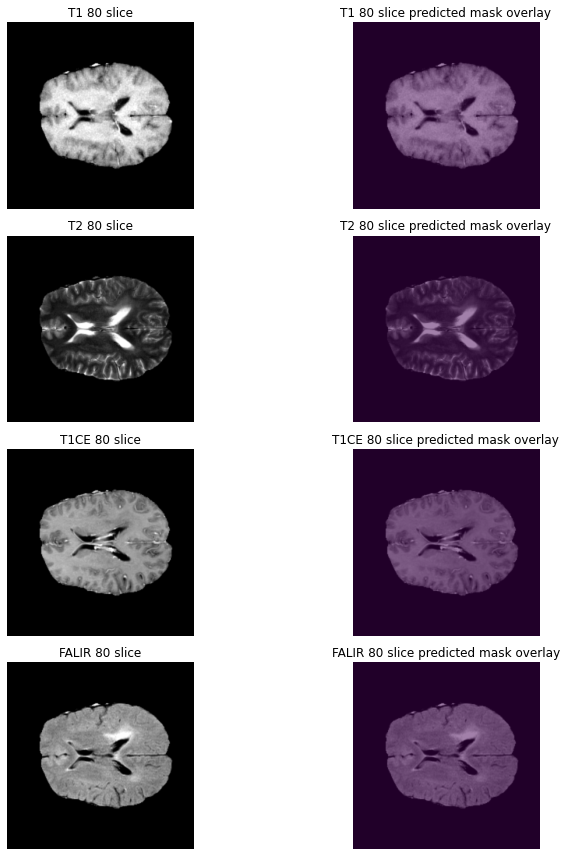

In [10]:
plot_results_for_validation(patient_data, segm_mask_otsu, 80) 

In [11]:
print("Dice score:")
print("\tOtsu", dice_score(segm_mask_otsu, patient_data[0,0]))
print("\tISODATA", dice_score(segm_mask_isodata, patient_data[0,0]))


print("Hausdorf Distance:")
print("\tOtsu", hausdorff_distance(segm_mask_otsu, patient_data[0,0]))
print("\tISODATA", hausdorff_distance(segm_mask_isodata, patient_data[0,0]))

Dice score:
	Otsu 0.43421643984004976
	ISODATA 0.0
Hausdorf Distance:
	Otsu 70.14983962918234
	ISODATA 70.14983962918234


# Running for All

In [12]:
otsu_dsc = []
otsu_h = []

isodata_dsc = []
isodata_h  = []
for test_patient in tqdm(validation_set):
    patient_data = retrieve_brats_data([test_patient], ['t1', 't2', 't1ce', 'flair'], dataset_part=dataset_part, brats_path=brats_path)
    segm_mask_otsu, segm_mask_isodata = threshold_patient(patient_data)
    otsu_dsc.append(dice_score(segm_mask_otsu, patient_data[0,0]))
    otsu_h.append(hausdorff_distance(segm_mask_otsu, patient_data[0,0]))
    
    isodata_dsc.append(dice_score(segm_mask_isodata, patient_data[0,0]))
    isodata_h.append(hausdorff_distance(segm_mask_isodata, patient_data[0,0]))

100%|██████████| 30/30 [03:05<00:00,  6.19s/it]


<AxesSubplot:xlabel='patients'>

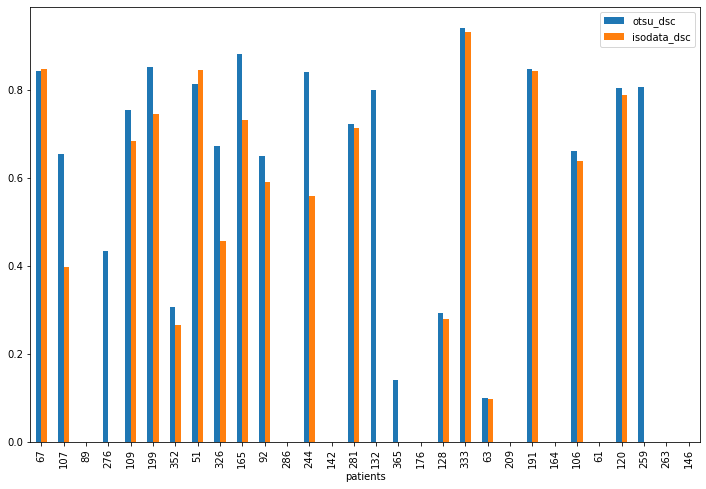

In [13]:
results[['otsu_dsc', 'isodata_dsc']].plot.bar(figsize=(12,8))

<AxesSubplot:>

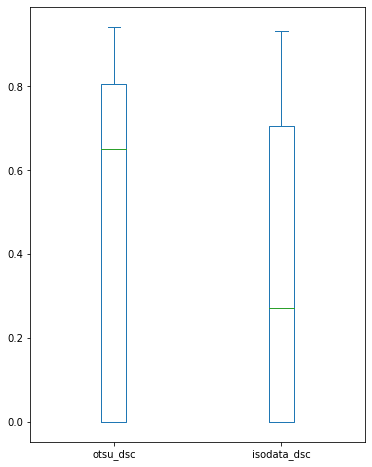

In [14]:
results[['otsu_dsc', 'isodata_dsc']].plot.box(figsize=(6,8))

In [15]:
print(results['isodata_dsc'].mean(), '+-', results['isodata_dsc'].std())

0.347132424897136 +- 0.35633038465820616
